# EM
- 混合ガウス分布から出力されたデータに対して, もとの分布のパラメータを推定する
- ガウス分布は3つ, パラメータは$\pi_k, \boldsymbol{\mu}, \boldsymbol{\Sigma}$
- Eステップではq(z)=p(z|x, θ)なので, 事後分布の計算を行う

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## データ生成
- データ数N
- クラス数K
- 次元数D
- 観測されたデータX

In [2]:
# ハイパーパラメータ
N = 300
K = 3
D = 2

# 隠れパラメータ
s1 = 0.25 / 10
s2 = 0.2 / 10

# データ生成
X1 = np.random.multivariate_normal([-0.4, 0], [[s1, s2],[s2, s1]], N//3)
X2 = np.random.multivariate_normal([ 0,   0], [[s1,-s2],[-s2,s1]], N//3)
X3 = np.random.multivariate_normal([ 0.4, 0], [[s1, s2],[s2, s1]], N//3)

# データ
X = np.random.permutation(np.concatenate([X1, X2, X3]))
print('data X shape:', X.shape)

data X shape: (300, 2)


## データの可視化

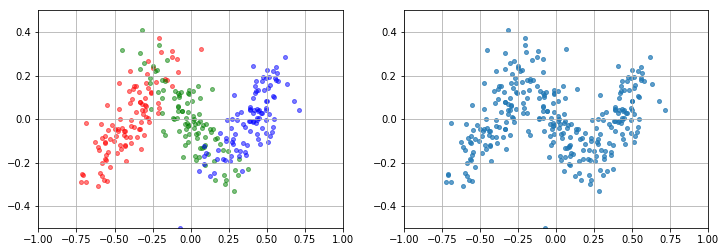

In [3]:
# データプロット
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(*X1.T, s=16, c='red', alpha=0.5)
plt.scatter(*X2.T, s=16, c='green', alpha=0.5)
plt.scatter(*X3.T, s=16, c='blue', alpha=0.5)
plt.xlim(-1, 1)
plt.ylim(-0.5, 0.5)
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(*X.T, s=16, alpha=0.7)
plt.xlim(-1, 1)
plt.ylim(-0.5, 0.5)
plt.grid()
plt.show()

## データの初期化
- piはランダムに初期化, 確率の条件を満たすように正規化
- muはランダムに初期化
- Sigmaは単位行列で初期化(ランダムにすると半正定値性満たさない場合がある)

In [4]:
# 学習するパラメータの初期化
def init_parameter():
    global pi, mu, Sig
    pi = np.random.rand(K)
    pi /= pi.sum()
    mu = np.random.uniform(-1, 1, size=(K, D))
    Sig = np.array([np.eye(D) for _ in range(K)])

init_parameter()
print('π_k shape:', pi.shape)
print('μ_k shape:', mu.shape)
print('Σ_k shape:', Sig.shape)

π_k shape: (3,)
μ_k shape: (3, 2)
Σ_k shape: (3, 2, 2)


## 関数
- 尤度関数
- 負担率
- 学習過程プロット関数

In [5]:
def get_likelihood(X, pi, mu, Sig):
    return np.log(np.array([pi[k] * stats.multivariate_normal.pdf(X, mean=mu[k], cov=Sig[k]) for k in range(K)]).sum(axis=0)).sum()
    
# 負担率
def get_responsibility(X, pi, mu, Sig):
    gamma = np.array([pi[k] * stats.multivariate_normal.pdf(X, mean=mu[k], cov=Sig[k]) for k in range(K)])
    return gamma / gamma.sum(axis=0)

_gamma = get_responsibility(X, pi, mu, Sig)
_Nk = _gamma.sum(axis=1)

lh = get_likelihood(X, pi, mu, Sig)
print('γ(z_nk) shape:', _gamma.shape)
print('N_k shape:', _Nk.shape, 'sum of Nk:', _Nk.sum())

def plot_graph(t, X, mu, Sig):
    xx, yy = np.meshgrid(np.arange(-1, 1, 0.01),np.arange(-0.5, 0.5, 0.01))
    h, w = xx.shape

    plt.figure(figsize=(6,4))
    grid = np.array([xx, yy]).reshape(2, -1).T
    for k in range(K):
        z = stats.multivariate_normal.pdf(grid, mean=mu[k], cov=Sig[k])
        plt.contour(xx, yy, z.reshape(h, w), alpha=0.4, cmap='coolwarm')

    plt.scatter(*X.T, s=12, marker='x', c=gamma.T, alpha=0.8)
    plt.xlim(-1, 1)
    plt.title('iter={:>03}'.format(t))
    plt.grid()
    plt.savefig('results/EM/EM_iter{:>03}.png'.format(t))
    plt.close()

γ(z_nk) shape: (3, 300)
N_k shape: (3,) sum of Nk: 300.0


## EMアルゴリズム本体

iter:  1, likelihood:   20.0367 	
iter:  2, likelihood:   20.3148 	
iter:  3, likelihood:   20.8373 	
iter:  4, likelihood:   21.6689 	
iter:  5, likelihood:   22.7748 	
iter:  6, likelihood:   24.0883 	
iter:  7, likelihood:   25.5700 	
iter:  8, likelihood:   27.2038 	
iter:  9, likelihood:   28.9950 	
iter: 10, likelihood:   30.9846 	
iter: 11, likelihood:   33.2204 	
iter: 12, likelihood:   35.6519 	
iter: 13, likelihood:   38.0419 	
iter: 14, likelihood:   40.0515 	
iter: 15, likelihood:   41.4717 	
iter: 16, likelihood:   42.3556 	
iter: 17, likelihood:   42.9318 	
iter: 18, likelihood:   43.4328 	
iter: 19, likelihood:   43.9592 	
iter: 20, likelihood:   44.4362 	
iter: 21, likelihood:   44.7947 	
iter: 22, likelihood:   45.0538 	
iter: 23, likelihood:   45.2442 	
iter: 24, likelihood:   45.3869 	
iter: 25, likelihood:   45.4961 	
iter: 26, likelihood:   45.5816 	
iter: 27, likelihood:   45.6504 	
iter: 28, likelihood:   45.7076 	
iter: 29, likelihood:   45.7568 	
iter: 30, like

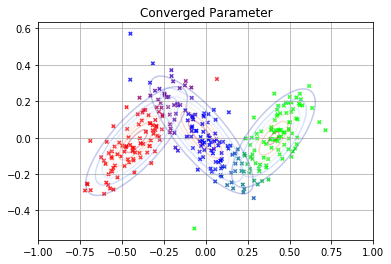

In [6]:
# init Parameter
init_parameter()
lh = get_likelihood(X, pi, mu, Sig)

for t in range(1, 100 + 1):
    # E Step
    gamma = get_responsibility(X, pi, mu, Sig)
    Nk = gamma.sum(axis=1)
    # M Step
    pi_new = Nk / N
    mu_new = (gamma@X) / Nk[:, np.newaxis]
    d = X[np.newaxis,:] - mu_new[:,np.newaxis]
    Sig_new = ((d[:,:,[[0,1], [0,1]]] * d[:,:,[[0,0], [1,1]]]) * gamma[:,:,np.newaxis, np.newaxis]).sum(axis=1) / Nk[:,np.newaxis, np.newaxis]
    
    pi = pi_new
    mu = mu_new
    Sig = Sig_new
    
    # save image
    plot_graph(t, X, mu, Sig)
    
    # calc likelihood
    lh_new = get_likelihood(X, pi, mu, Sig)
    if np.abs(lh_new - lh) < 10e-4:
        print('converged!')
        break
    lh = lh_new
    print('iter:{:>3}, likelihood:{:>10.4f} \t'.format(t, lh))
    
# 最終結果 プロット
xx, yy = np.meshgrid(np.arange(-1, 1, 0.01),np.arange(-0.5, 0.5, 0.01))
h, w = xx.shape

plt.figure(figsize=(6,4))
grid = np.array([xx, yy]).reshape(2, -1).T
for k in range(K):
    z = stats.multivariate_normal.pdf(grid, mean=mu[k], cov=Sig[k])
    plt.contour(xx, yy, z.reshape(h, w), alpha=0.3, cmap='coolwarm')

plt.scatter(*X.T, s=12, marker='x', c=gamma.T, alpha=0.8)
plt.xlim(-1, 1)
plt.title('Converged Parameter')
plt.grid()
plt.show()